<a href="https://colab.research.google.com/github/migostro/laboratorio-de-visao/blob/main/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive
import os
import cv2
import imageio
from skimage import filters
import skimage

In [ ]:
def setFigSize():
    return((10,10))

def myImgShow(img):
    plt.figure(figsize=setFigSize())
    plt.axis('equal')
    plt.imshow(img,cmap='gray')
    plt.show()


###1 - Soma de gradiente

In [ ]:
# recebe as dimensões da imagem
# constroi e retorna o gradiente com o tamanho da imagem
def calcula_gradiente(dim):
    n = dim[0]
    m = dim[1]

    linha = np.array(np.arange(m))

    matriz = np.array([])

    for i in range(n):
        matriz = np.concatenate([matriz, linha])
    #matriz = np.concatenate([matriz, matriz, matriz])
    matriz = np.reshape(matriz, [dim[0], dim[1]])

    gradiente = np.zeros(dim)
    gradiente[:,:,0] = matriz.copy()
    gradiente[:,:,1] = matriz.copy()
    gradiente[:,:,2] = matriz.copy()

    max = m-1
    ##################################### SOMANDO #########################################
    gradiente = (gradiente/max)*255/2
    gradiente = gradiente.astype(np.uint16)

    ##################################### MULTIPLICANDO ###################################
    # gradiente = (gradiente/max)

    return gradiente

# Recebe uma imagem e um gradiente preciamente calculado
# Retorna a imagem com o gradiente
def aplica_gradiente(img, gradiente):
    ##################################### SOMANDO #########################################
    nova_imagem = img/2 + gradiente
    #max = np.max(nova_imagem)
    #nova_imagem = (nova_imagem/max)*255
    
    ##################################### MULTIPLICANDO ###################################
    # nova_imagem = np.multiply(img, gradiente)

    nova_imagem = nova_imagem.astype(np.uint8)
    return nova_imagem

###2 - Logaritmo da imagem

In [ ]:
def aplica_logaritmo(img):

    nova_imagem = img.astype(np.uint16)
    nova_imagem = nova_imagem + 1
    
    nova_imagem = np.log2(nova_imagem)

    nova_imagem = nova_imagem*32
    nova_imagem[nova_imagem > 255] = 255
    nova_imagem = nova_imagem.astype(np.uint8)

    return nova_imagem

###3 - Exponencial da imagem

In [ ]:
def aplica_exponencial(img):
    # pixels da imagem ficam entre [0 ,1]
    nova_imagem = img/255

    # pixels ficam entre [1, 2]
    nova_imagem = nova_imagem + 1
    #print("+1 min: ", np.min(nova_imagem), " max: ", np.max(nova_imagem))
    #print(nova_imagem)
    # pixels ficam entre [e, e^2]
    nova_imagem = np.exp(nova_imagem)
    #print("e^x min: ", np.min(nova_imagem), " max: ", np.max(nova_imagem))
    # pixels ficam entre [0, e^2-e]
    nova_imagem = nova_imagem - np.exp(1)
    #print("-e min: ", np.min(nova_imagem), " max: ", np.max(nova_imagem))
    # pixels ficam entre [0, 1]
    nova_imagem = nova_imagem/(np.exp(2)-np.exp(1))
    #print("/(e^x-e) min: ", np.min(nova_imagem), " max: ", np.max(nova_imagem))

    # pixels ficam entre [0, 255]
    nova_imagem = nova_imagem*255

    #nova_imagem = nova_imagem.astype(np.uin)
    #print(nova_imagem)
    #print(nova_imagem - np.exp(1))
    #nova_imagem = (nova_imagem - 1)*255
    nova_imagem = nova_imagem.astype(np.uint8)
    return nova_imagem

###4 - Filtro da média implementado usando convolução

In [ ]:
def copia_imagem(imagem):
    num_linhas = imagem.shape[0]
    num_colunas = imagem.shape[1]

    copia = np.zeros([num_linhas+2, num_colunas+2])

    #copia o meio
    copia[1:num_linhas+1, 1:num_colunas+1] = imagem.copy()
    
    # copia as 4 bordas da imagem
    copia[1:num_linhas+1, 0] = imagem[0:num_linhas, 0].copy()
    copia[0, 1:num_colunas+1] = imagem[0, 0:num_colunas].copy()
    copia[1:num_linhas+1, num_colunas+1] = imagem[0:num_linhas, num_colunas-1].copy()
    copia[num_linhas+1, 1:num_colunas+1] = imagem[num_linhas-1, 0:num_colunas].copy()

    # copia as pontas da imagem
    copia[0, 0] = imagem[0, 0]
    copia[0, num_colunas+1] = imagem[0,num_colunas-1]
    copia[num_linhas+1, 0] = imagem[num_linhas-1,0]
    copia[num_linhas+1,num_colunas+1] = imagem[num_linhas-1,num_colunas-1]

    # transforma em inteiro
    copia = copia.astype(np.uint8)

    return copia


# Recebe uma imagem e uma mascara
# a mascara deve ser quadrada e com comprimento ímpar
# retorna uma imagem com a mascara aplicada
def filtra(imagem, mascara):

    copia = copia_imagem(imagem)

    imagem_filtrada = np.zeros(imagem.shape)

    n = np.arange(1, imagem.shape[0]+1)
    m = np.arange(1, imagem.shape[1]+1)

    for i in n:
        for j in m:
            imagem_filtrada[i-1,j-1] = np.sum(np.multiply(copia[i-1:i+2,j-1:j+2], mascara))
    #puta = np.mean(copia[0:3,0:3])
    #print(puta)
    
    return imagem_filtrada

# recebe o raio que o filtro afetara
def aplica_media(imagem):
    mascara = np.ones([3,3])/9
    #nova_imagem = np.ones(imagem.shape)
#
    #nova_imagem[:,:,0] = filtra(imagem[:,:,0], mascara)
    #nova_imagem[:,:,1] = filtra(imagem[:,:,1], mascara)
    #nova_imagem[:,:,2] = filtra(imagem[:,:,2], mascara)
    nova_imagem = cv2.filter2D(imagem, -1, mascara)
    nova_imagem = nova_imagem.astype(np.uint8)

    return nova_imagem

###Aplica e os métodos e salva as imagens formadas

In [ ]:
drive.mount('/content/drive')

pasta_mae = '/content/drive/MyDrive/ime-usp/9º semestre/visao/ep/fotos/luminosidade-dentro-noite/luminosidade-dentro-noite'

# código pego e adaptado de https://pt.stackoverflow.com/questions/63097/listar-arquivos-de-um-pasta-em-python
caminhos = [os.path.join(pasta_mae, nome) for nome in os.listdir(pasta_mae)]
arquivos = [arq for arq in caminhos if os.path.isfile(arq)]
jpgs = [arq for arq in arquivos if arq.lower().endswith(".jpg")]

caminhos = []

# Algoritmo recursivo que recebe a pasta_raiz que estão as imagens e uma lista vazia caminhos
# Retorna todos os caminhos até as imagens
def monta_caminhos(pasta_raiz, caminhos = []):
    for nome in os.listdir(pasta_raiz):
        caminho = os.path.join(pasta_raiz, nome)

        # Adiciona apenas caminhos que são de arquivos (que no nosso caso são imagens)
        if os.path.isfile(caminho):
            caminhos.append(caminho)
        else:
            monta_caminhos(caminho, caminhos)
    return caminhos

caminhos = monta_caminhos(pasta_mae)
jpgs = [arq for arq in caminhos if arq.lower().endswith(".jpg")]
novo = []
for i in jpgs:
    novo.append(i.split('/')[-1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(novo)

['IMG_20220505_190353.jpg', 'IMG_20220505_190354.jpg', 'IMG_20220505_190355.jpg', 'IMG_20220505_190329.jpg', 'IMG_20220505_190330.jpg', 'IMG_20220505_190331.jpg', 'IMG_20220505_190342.jpg', 'IMG_20220505_190344.jpg', 'IMG_20220505_190345.jpg', 'IMG_20220505_185852.jpg', 'IMG_20220505_185855.jpg', 'IMG_20220505_185856.jpg', 'IMG_20220505_190307.jpg', 'IMG_20220505_190309.jpg', 'IMG_20220505_190310.jpg', 'IMG_20220505_190318.jpg', 'IMG_20220505_190320.jpg', 'IMG_20220505_190321.jpg', 'IMG_20220505_185613.jpg', 'IMG_20220505_185614.jpg', 'IMG_20220505_185615.jpg', 'IMG_20220505_185605.jpg', 'IMG_20220505_185607.jpg', 'IMG_20220505_185608.jpg', 'IMG_20220505_185554.jpg', 'IMG_20220505_185555.jpg', 'IMG_20220505_185556.jpg', 'IMG_20220505_185638.jpg', 'IMG_20220505_185637.jpg', 'IMG_20220505_185639.jpg', 'IMG_20220505_185625.jpg', 'IMG_20220505_185626.jpg', 'IMG_20220505_185627.jpg', 'IMG_20220505_185646.jpg', 'IMG_20220505_185647.jpg', 'IMG_20220505_185648.jpg', '20220425_180537.jpg', '202

In [ ]:
print(len(caminhos))

74


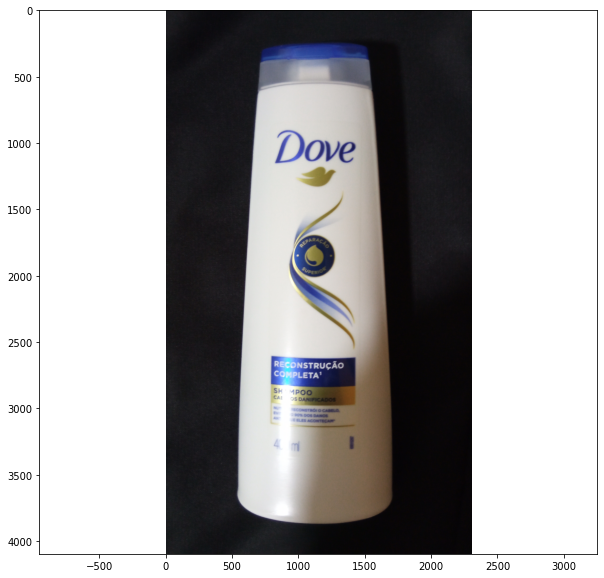

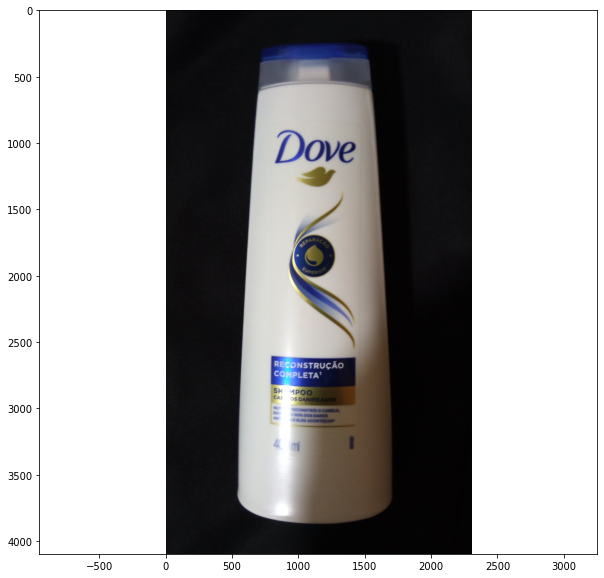

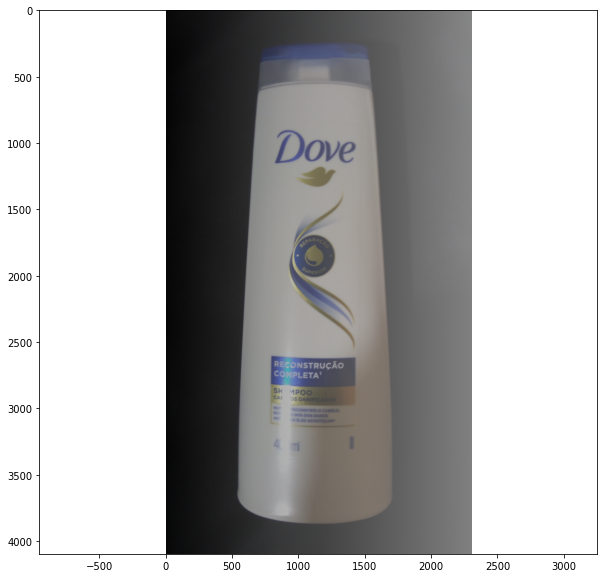

In [ ]:
############## testes ####################

img = imageio.imread(caminhos[0])
myImgShow(img)



imagem_teste = aplica_exponencial(img)
myImgShow(imagem_teste)

grad = calcula_gradiente(imagem_teste.shape)
imagem_grad = aplica_gradiente(imagem_teste, grad)

myImgShow(imagem_grad)

imageio.imsave('/content/drive/MyDrive/ime-usp/9º semestre/visao/ep/fotos/teste/imagem1teste.jpg', imagem_teste)

In [ ]:
imagem_log = aplica_logaritmo(img)
imagem_media = aplica_media(img)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)
#imagem_media = aplica_media(imagem_media)

In [ ]:
print(np.min(imagem_log))
print(np.max(imagem_log))

0
255


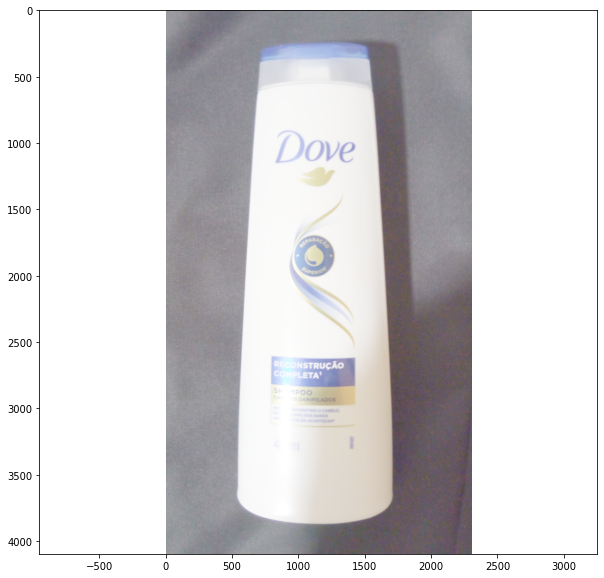

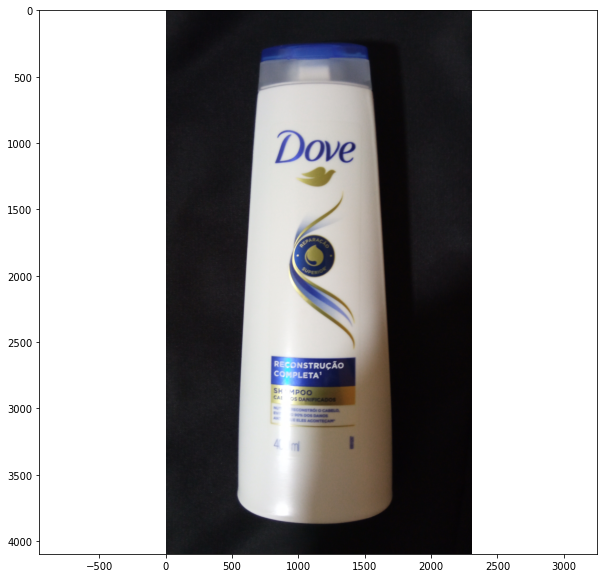

In [ ]:
myImgShow(imagem_log)
myImgShow(imagem_media)


In [ ]:
#myImgShow(grad)
#print(np.max(grad))

In [ ]:
#print(np.max(imagem_grad))
#print(np.min(imagem_grad))

In [ ]:
# calcula previamente o gradiente
img = imageio.imread(caminhos[0])
gradiente = calcula_gradiente(img.shape)

In [ ]:
local_pasta = '/content/drive/MyDrive/ime-usp/9º semestre/visao/ep/fotos/teste'

for caminho in caminhos:
    imagem_original = imageio.imread(caminho)
    nome_arquivo = caminho.split('/')[-1]

    #if imagem_original.shape[0] != gradiente.any():
    #    gradiente = calcula_gradiente(imagem_original.shape)

    imagem_media =       aplica_media(imagem_original)
    imagem_log =         aplica_logaritmo(imagem_original)
    imagem_exponencial = aplica_exponencial(imagem_original)
    imagem_gradiente =   aplica_gradiente(imagem_original, gradiente)

    arquivo_media       = 'media_'          + nome_arquivo
    arquivo_log         = 'log_'            + nome_arquivo
    arquivo_exponencial = 'exponencial_'    + nome_arquivo
    arquivo_gradiente   = 'gradiente_'      + nome_arquivo
    # print(arquivo_media)

    imageio.imsave(os.path.join(local_pasta, arquivo_media),        imagem_media)
    imageio.imsave(os.path.join(local_pasta, arquivo_log),          imagem_log)  
    imageio.imsave(os.path.join(local_pasta, arquivo_exponencial),  imagem_exponencial)  
    imageio.imsave(os.path.join(local_pasta, arquivo_gradiente),    imagem_gradiente)

ValueError: ignored